In [1]:
import numpy as np
import cv2
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle
import glob
from scipy import ndimage as nd
from skimage.filters import roberts, sobel, scharr, prewitt, meijering, sato, hessian
from matplotlib import pyplot as plt

In [5]:
import sys
sys.path.append('../tools')
from rf_tools import extract_features


Import folders for original images and correspondent masks.
Make sure that mask correspond to the image when running the for loop.

# Test model using a validation image. Compare prediction with the annotated mask.

- The following functions will extract color channel information for each single pixel in the validation image.
- Compare the original mask (annotated mask) with the segmented mask.

In [6]:
path_rgb = '../images/validation_imgs/original_rgb/73_rgb.jpg'
path_mask = '../images/validation_imgs/original_mask/73_mask.jpg'
shape_mask = cv2.imread(path_mask,0).shape
shape_mask

(960, 1920)

## NOTICE: Feature extraction step must match the color and texture features used to train the model.
Model: All color texture

# Color Image Preview

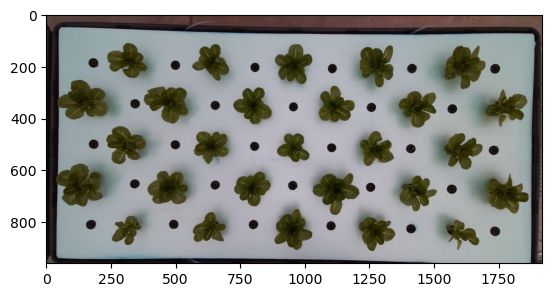

In [7]:
#from google.colab.patches import
# Notice that cv2 reads it as BGR
img_bgr = cv2.imread(path_rgb, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

#window_name = "Image"
plt.imshow(img_rgb)  # Pay special attention to "_" (underscore)
#plt.imshow(mask_norm)

## Apply function to extract color information from a validation image.

In [8]:
color_features = extract_features(path_rgb)
color_features.head()

,B channel(RGB),G channel(RGB),R channel(RGB),H channel(HSV),S channel(HSV),V channel(HSV),L channel(LAB),A channel(LAB),B channel(LAB),Canny,Roberts,Sobel,Scharr,Prewitt,Grayscale
0,63,67,85,5,66,66,135,135,134,0,0.002773,0.002192,0.002312,0.002067,72
1,64,68,86,5,65,65,135,135,133,0,0.002773,0.003100,0.003270,0.002923,73
2,64,68,86,5,65,65,135,135,133,0,0.002773,0.001386,0.001040,0.001849,73
3,64,68,86,5,65,65,135,135,133,0,0.003922,0.002192,0.002312,0.002067,73
4,64,68,86,5,65,65,135,135,133,0,0.002773,0.002192,0.002312,0.002067,73


Model predict function will yield a prediction per pixel based on pixel intensity. We need to keep a binary mask for it to be comparable with other models predictions.
- Step 1: Rescale image from 0-255 to 0-1.
- Step 2: Threshold pixel values to keep only values over 0.5 as plant pixels. Otherwise, it is part of the background.
- Step 3: After the boolean operator ">" transform false and true values to integers 0 and 1.

In [9]:
filename = '../model_weights/02-05_RF-color-texture_black_V1.0'
load_model = pickle.load(open(filename,'rb'))

## Mask prediction using model weights


Run a prediction and reshape that prediction the same resolution as the mask

In [10]:
predicted_mask = load_model.predict(color_features).reshape(shape_mask)

[0 1]


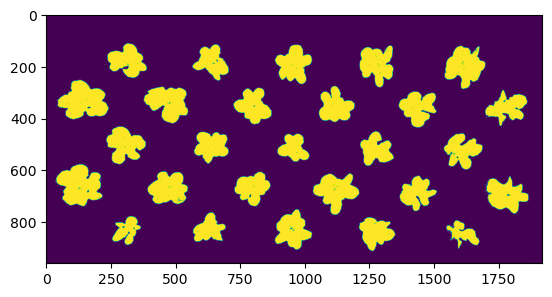

In [11]:
print(np.unique(predicted_mask))
plt.imshow(predicted_mask)

## Original MASK
Transform pixel intensities into a binary image with values of either 0 or 1 to be able to compare between mask and prediction


[0 1]


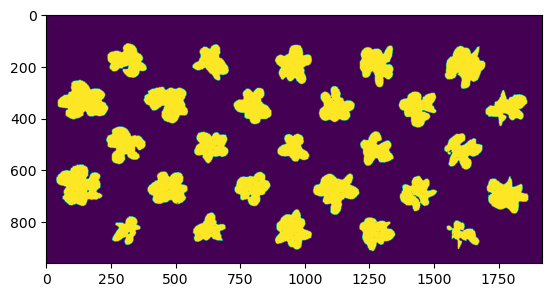

In [12]:
original_mask = cv2.imread(path_mask,0) # read as grayscale
original_mask = cv2.normalize(original_mask, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print(np.unique(original_mask))
plt.imshow(original_mask)

# Model Metrics on validation images. Metrics we will include:


In [13]:
from sklearn.metrics import precision_score, recall_score,f1_score,jaccard_score

def seg_metrics(true_mask,predicted_mask):
    # Flatten the masks if they are not already flattened
    y_true = true_mask.flatten()
    y_pred = predicted_mask.flatten()

    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred) # IOU

    return precision,recall,f1,jaccard

In [14]:
rf_precision, rf_recall,rf_f1, rf_jaccard = seg_metrics(original_mask,predicted_mask)
metrics_dict_rf = {'Precision': rf_precision,"Recall":rf_recall, 'F1_Score': rf_f1, 'Jaccard (IOU)': rf_jaccard}
rf_metrics = pd.DataFrame([metrics_dict_rf])
rf_metrics

,Precision,Recall,F1_Score,Jaccard (IOU)
0,0.989014,0.987992,0.988503,0.977268


### Classification Report

In [53]:
from sklearn.metrics import classification_report


def get_classification_score(y_true, y_pred):
    # Flatten the masks if they are not already flattened
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate the F1 score
    score = classification_report(y_true, y_pred)

    return score

class_report = get_classification_score(original_mask, predicted_mask)
print(class_report)

## Function will take expected and predicted values to output a data frame with the classification
## report that includes precision, recall, f1_score, support.

def get_classification_score(y_true, y_pred):
    # Flatten the masks if they are not already flattened
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate the classification report
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Convert the classification report dictionary to a DataFrame
    report_df = pd.DataFrame(report_dict).transpose()

    return report_df

report_df = get_classification_score(original_mask, predicted_mask)
print(report_df)

#report_df.to_csv('/content/drive/MyDrive/random_forest/implement_model/classification_report.csv')



              precision    recall  f1-score   support

           0       0.99      0.96      0.97   1363704
           1       0.89      0.98      0.93    479496

    accuracy                           0.96   1843200
   macro avg       0.94      0.97      0.95   1843200
weighted avg       0.97      0.96      0.96   1843200

              precision    recall  f1-score       support
0              0.993794  0.955688  0.974369  1.363704e+06
1              0.886368  0.983026  0.932198  4.794960e+05
accuracy       0.962800  0.962800  0.962800  9.628000e-01
macro avg      0.940081  0.969357  0.953283  1.843200e+06
weighted avg   0.965848  0.962800  0.963398  1.843200e+06


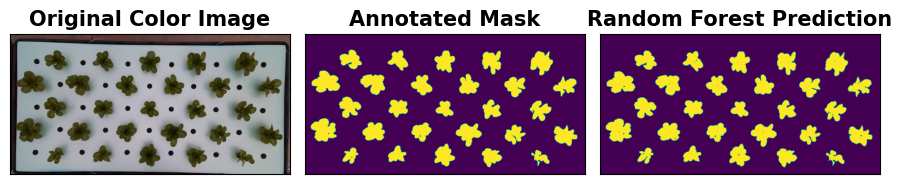

In [15]:
images = [img_rgb, original_mask, predicted_mask]
titles = ['Original Color Image', 'Annotated Mask', 'Random Forest Prediction']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Iterate through subplots and data
for ax, image, title in zip(axs.flatten(), images, titles):
    ax.imshow(image)
    if title:
        ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
#plt.savefig('../output/01-05_UNet.png', dpi=350)